In [1]:
import time
import klepto
import shelve
import pickle
import h5py
import numpy as np
import scipy.io as sio
from scipy.sparse import *
import matplotlib.pyplot as plt

## Load

In [2]:
dataset = '20m'

- load train_list & test_list

In [3]:
feature=h5py.File('movielens/' + dataset + '/test_list.mat')  
test_list = feature['test_list'][:]
test_list = list(map(int, test_list.T[0]))
test_list = [i-1 for i in test_list] 
feature=h5py.File('movielens/' + dataset + '/train_list.mat')  
train_list = feature['train_list'][:]
train_list = list(map(int, train_list.T[0]))
train_list = [i-1 for i in train_list] 

In [4]:
feature.close()

- load full sparse matrix

In [5]:
rating_matrix = load_npz('movielens/sparse_matrix_ml-' + dataset + '_selected.npz').tocsc()
rating_matrix_train = rating_matrix[:, train_list]
rating_matrix_test  = rating_matrix[:, test_list]
print("file load DONE")

file load DONE


- load tree file: lr_bound & tree

In [6]:
with h5py.File('treeFile/lr_bound.mat') as data:
    lr_bound_list = [data[element[0]][:] for element in data['lr_bound']]

depth_threshold = len(lr_bound_list)
i = 0
for i in range(len(lr_bound_list)):
    level = lr_bound_list[i]
    lr_bound_list[i] = []
    level = list((level.T)[0])
    for boundNum in range(0, len(level), 2):
        lr_bound_list[i].append([int(level[boundNum]) - 1, int(level[boundNum + 1]) - 1])
    i += 1

lr_bound = {}
for i in range(len(lr_bound_list)):
    lr_bound[str(i)] = lr_bound_list[i]

In [7]:
feature=h5py.File('treeFile/tree.mat')  
tree = list(feature['tree'][:].T[0])
tree = [i-1 for i in tree]

In [8]:
feature.close()

## MF part

In [9]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS

class MatrixFactorization:
    def __init__(self, maxIter=15, regParam=0.01, rank=10):
        self.maxIter = maxIter
        self.regParam = regParam
        self.rank = rank
        conf = SparkConf().setAppName("appName").setMaster("local[*]")
        conf.set("spark.driver.memory","14g")
        conf.set("spark.executor.memory","14g")       
        self.spark = SparkContext(conf=conf)            
        print("New SparkSession started...")

    def change_parameter(self, regParam):
        self.regParam = regParam

    def matrix_factorization(self, train_lst):
        ratings = self.spark.parallelize(train_lst)
        model = ALS.train(ratings, self.rank, seed=10, \
                          iterations=self.maxIter, \
                          lambda_=self.regParam)
        print("MF DONE")
        productFeatures = sorted(model.userFeatures().collect(), key=lambda d: d[0], reverse=False)
        userFeatures = sorted(model.productFeatures().collect(), key=lambda d: d[0], reverse=False)
        itemProfile = {each[0]: each[1].tolist() for each in productFeatures}
        userProfile = {each[0]: each[1].tolist() for each in userFeatures}
             
        return userProfile, itemProfile

    def end(self):
        self.spark.stop()
        print("SparkSession stopped.")

In [10]:
lambda_list = [0.005, 0.025, 0.05, 0.06, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]

In [ ]:
MF = MatrixFactorization()

New SparkSession started...


In [ ]:
prediction_model = {}
rmst_dict = {"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[]}
min_rmse_list = []

for level in range(depth_threshold):
    with h5py.File('treeFile/targetNode_' + str(level + 1) + '.mat') as data:
        targetNode = [data[element[0]][:] for element in data['targetNode']]
    with h5py.File('treeFile/rated_user_' + str(level + 1) + '.mat') as data:
        rated_users = [data[element[0]][:] for element in data['rated_user']]
    0                    
    level = str(level)
    print("level:", level)    
                   
    prediction_model.setdefault(level, {})
    train_lst = []    
    
    for pseudo_item_bound, itemid in zip(lr_bound[level], range(len(lr_bound[level]))):
        if pseudo_item_bound[0] > pseudo_item_bound[1]:
            continue
        pseudo_item_lst = tree[pseudo_item_bound[0]:(pseudo_item_bound[1] + 1)]
        pseudo_matrix = np.array(rating_matrix_train[:, pseudo_item_lst].sum(axis=1))[:,0] / \
                                     (rating_matrix_train[:, pseudo_item_lst].getnnz(axis=1)+1e-9)
        train_lst += [(itemid, userid, float(pseudo_matrix[userid])) \
                      for userid in range(pseudo_matrix.shape[0]) if pseudo_matrix[userid]]        

    print("Rating Number of level " + level + ": " + str(len(train_lst)))
    
    #### Train MF and Do validation ####
    min_RMSE = -1
    user_profile_list = []
    item_profile_list = []
    for plambda in lambda_list:
#         if int(level) == 5 and plambda <= 0.075:
#             continue
        print("Current plambda: " + str(plambda))
        MF.change_parameter(plambda)
        user_profile, item_profile = MF.matrix_factorization(train_lst)
        user_profile_list.append(user_profile)
        item_profile_list.append(item_profile)
        
        P = np.dot(np.array(list(user_profile.values())), np.array(list(item_profile.values())).T)            
        P_test = np.zeros(rating_matrix_test.shape)
        rating_matrix_test_unqueried = rating_matrix_test.toarray()
        for itemid in range(rating_matrix_test.shape[1]):
#             if itemid  % 2000 == 0:
#                 print("%.2f%%" % (100 * itemid / rating_matrix_test.shape[1]))      
            pred_index = int(targetNode[itemid].T[0][1]) - 1
            final_level = int(targetNode[itemid].T[0][0]) - 1
            if rated_users[itemid].sum() == 0 or np.sum(rated_users[itemid] == [1, 0]):
                rated_user = []
            else:
                rated_user = [int(i-1) for i in list(set(rated_users[itemid][0]))]
                
            P_test[:, itemid] = P[:, pred_index]
            rating_matrix_test_unqueried[rated_user, itemid] = 0

        rating_matrix_test_unqueried = csc_matrix(rating_matrix_test_unqueried)
        P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
        dif = P_test - rating_matrix_test_unqueried
        RMSE = ( dif.multiply(dif).sum() / (rating_matrix_test_unqueried!=0).sum() )**0.5
        print("Current RMSE: " + str(RMSE))
        print("--------------------------------")
        rmst_dict[level].append(RMSE)
        
    min_MF = rmst_dict[level].index(min(rmst_dict[level]))   
    prediction_model[level]['upro'] = user_profile_list[min_MF]
    prediction_model[level]['ipro'] = item_profile_list[min_MF]
    prediction_model[level]['plambda'] = lambda_list[min_MF]
    print("min RMSE: " + str(min(rmst_dict[level])))
    min_rmse_list.append(min(rmst_dict[level]))
    
    plt.figure(1)
    plt.title('RMSE for level ' + level)
    plt.xlabel('plambda')
    plt.ylabel('RMSE')
    plt.plot(lambda_list, rmst_dict[level])
    plt.show()

level: 0
Rating Number of level 0: 138493
Current plambda: 0.005
MF DONE
Current RMSE: 0.968441530361
--------------------------------
Current plambda: 0.025
MF DONE
Current RMSE: 0.968567568721
--------------------------------
Current plambda: 0.05
MF DONE


In [ ]:
MF.end()

In [51]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)
Tree['prediction_model_20m_1'] = prediction_model
Tree.dump()
Tree.clear()

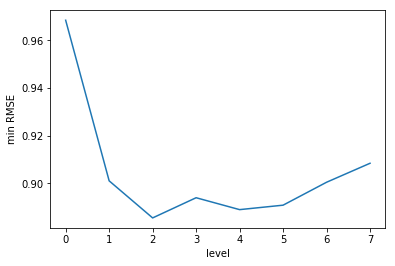

In [52]:
plt.figure(1)
plt.xlabel('level')
plt.ylabel('min RMSE')
plt.plot(list(range(depth_threshold - 1)), min_rmse_list)
plt.show()

In [53]:
for i in range(depth_threshold - 1):
    sio.savemat('rmse_list' + str(i) + '.mat', {'rmse_list': rmst_dict[str(i)]})

In [54]:
sio.savemat('min_rmse_list.mat', {'min_rmse_list':min_rmse_list})

In [55]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
Tree.load()
prediction_model = Tree['prediction_model_20m_1']

In [56]:
level = 2

with h5py.File('treeFile/targetNode_' + str(level + 1) + '.mat') as data:
    targetNode = [data[element[0]][:] for element in data['targetNode']]
with h5py.File('treeFile/rated_user_' + str(level + 1) + '.mat') as data:
    rated_users = [data[element[0]][:] for element in data['rated_user']]

level = str(level)
print("level:", level)    
P = np.dot(np.array(list(prediction_model[level]['upro'].values())), np.array(list(prediction_model[level]['ipro'].values())).T)
P_test = np.zeros(rating_matrix_test.shape)
rated_matrix = np.zeros(rating_matrix_test.shape)
rating_matrix_test_unqueried = rating_matrix_test.toarray()
for itemid in range(rating_matrix_test.shape[1]):  
    pred_index = int(targetNode[itemid].T[0][1]) - 1
    final_level = int(targetNode[itemid].T[0][0]) - 1
    if rated_users[itemid].sum() == 0 or np.sum(rated_users[itemid] == [1, 0]):
        rated_user = []
    else:
        rated_user = [int(i-1) for i in list(set(rated_users[itemid][0]))]

    P_test[:, itemid] = P[:, pred_index]
    rating_matrix_test_unqueried[rated_user, itemid] = 0
    rated_matrix[rated_user, itemid] = 1

rating_matrix_test_unqueried = csc_matrix(rating_matrix_test_unqueried)
P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
dif = P_test - rating_matrix_test_unqueried
RMSE = ( dif.multiply(dif).sum() / (rating_matrix_test_unqueried!=0).sum() )**0.5
print("Current RMSE: " + str(RMSE))
rated_matrix = rated_matrix==0

level: 2
Current RMSE: 0.885516526561


In [57]:
with shelve.open("P_test.pkl", protocol=pickle.HIGHEST_PROTOCOL) as d:
    d['content'] = P_test
with shelve.open("rated_matrix.pkl", protocol=pickle.HIGHEST_PROTOCOL) as d:
    d['content'] = rated_matrix